# Fari K-median: Bias measuring and mitigation in clustering tasks

The bias problem can appear in models when the predictions systematically deviate from the true values for certain subgroups in the dataset. This phenomenon can occur due to various reasons such as unbalanced groups in the training data, feature selection, or model specification. Because of this, the bias problem can appear in different tasks, being "clustering task" one of them. 

There are various techniques to measure bias in clustering tasks. One common approach is to use fairness metrics such as Fair K-Center Clustering, Fair K-Median Clustering, Fairlet Clustering, Variational Fair Clustering etc.

Once bias is detected, we can employ different techniques to mitigate it. These methods can be grouped into three categories: Pre-processing, in-processing and post-processing methods. Pre-processing techniques are used to adjust the training data to remove bias, while in-processing methods are applied to build robust models against bias. Finally, post-processing techniques are used to adjust the model's predictions to remove bias.

Through this tutorial, we pretend to present you tools which can be easily applied to measure and mitigate the presence of bias in clustering models.

We will follow the traditional outline for this tutorial:

1. Data loading and packages installation
2. Data exploration
3. Dataset preprocessing
4. Model training
5. Bias measuring
6. Bias mitigation
7. Results comparison

## Load dataset

The dataset that we will use is the "Heart Failure Clinical Records" dataset which is a publicly available dataset that contains the medical records of 299 patients who had heart failure, collected during their follow-up period, where each patient profile has 13 clinical features. The objective is to predict if the patient deceased during the follow-up period.

Source: [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records)

### Imports

In [246]:
#sys
import sys
sys.path.append('../../../../')

In [247]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Analyse Dataset

In [248]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


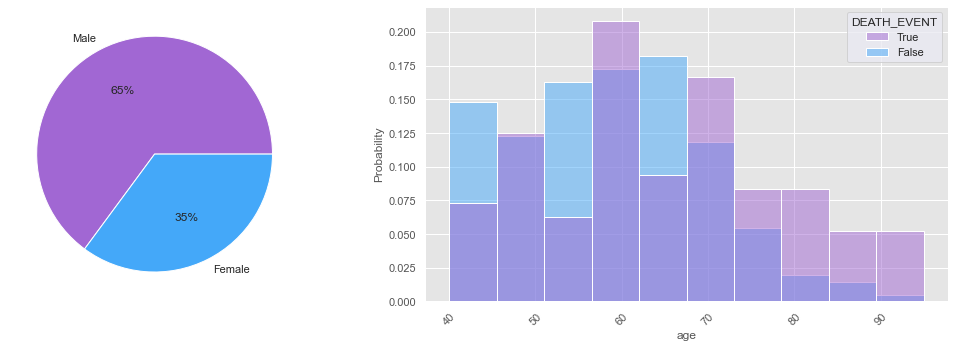

In [249]:
from holisticai.bias.plots import group_pie_plot, histogram_plot

fig, axes = plt.subplots(nrows = 1, ncols =2, figsize=(15,5))
group_pie_plot(df['sex'].replace({1:'Male', 0:'Female'}), ax = axes[0])
histogram_plot(df['age'], df['DEATH_EVENT'].replace({1:'True', 0:'False'}), ax = axes[1])
plt.tight_layout()

In [250]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

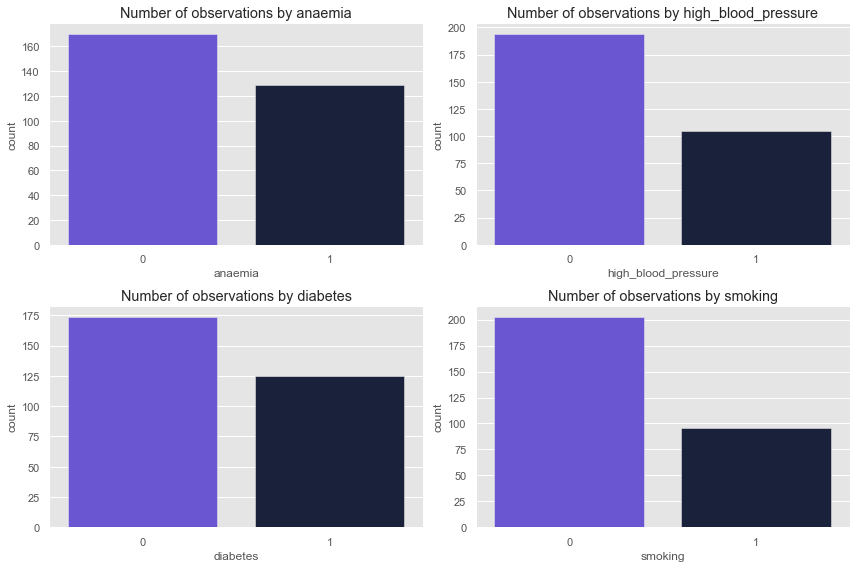

In [251]:
colors = ["#5b42e4", "#141e41"]
plt.style.use('ggplot')
haiPallete = sns.set_palette(sns.color_palette(colors))

fig, axes = plt.subplots(ncols=2, nrows= 2, figsize=(12,8))
cols = ['anaemia', 'high_blood_pressure','diabetes','smoking']
for i, ax in zip(cols, axes.flat):
    sns.countplot(x=i, data=df, ax = ax, palette=haiPallete).set_title(f'Number of observations by {i}')
    plt.tight_layout()

## Train Baseline

In [252]:
from sklearn.model_selection import train_test_split

# Dataframe
protected_variables = ["sex", "age"]
output_variable = ["DEATH_EVENT"]

# Simple preprocessing
y = df[output_variable]
X = df.drop(protected_variables + output_variable, axis=1)

group_a = df['sex'] == 0
group_b = df['sex'] == 1

X_train,X_test,y_train,y_test, group_a_tr, group_a_ts, group_b_tr, group_b_ts = \
    train_test_split(X, y, group_a, group_b, test_size=0.2, random_state=42)
train_data = X_train, y_train, group_a_tr, group_b_tr
test_data  = X_test, y_test, group_a_ts, group_b_ts

In [253]:
from sklearn.cluster import KMeans

ks = range(1, 8)
inertias = []
X_train, _, group_a_train, group_b_train = train_data

for k in ks:
    # create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)

    # fit model to samples
    model.fit(X_train)

    # append the inertia to the list of inertias
    inertias.append(model.inertia_)

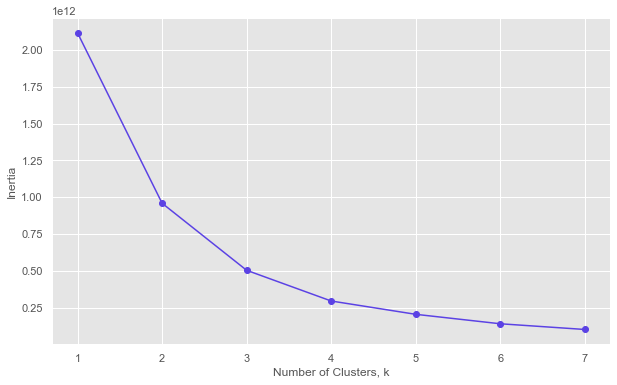

In [254]:
# Plot ks vs inertias
plt.figure(figsize=(10,6))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [255]:
# we choose to use 3 clusters
model = KMeans(n_clusters = 3)
model.fit(X_train)

# test data
X, _, group_a, group_b = test_data

# predict
y_pred = model.predict(X)

In [256]:
from holisticai.bias.metrics import clustering_bias_metrics

# set up data arrays
y_pred = y_pred
centroids = model.cluster_centers_
data = X.to_numpy()

df_ = clustering_bias_metrics(group_a, group_b, y_pred, data = data, centroids = centroids, metric_type = 'equal_outcome')
df_baseline=df_.copy()
df_baseline

,Value,Reference
Metric,,
Cluster Balance,0.500000,1
Minimum Cluster Ratio,0.200000,1
Cluster Distribution Total Variation,0.300000,0
Cluster Distribution KL Div,0.189714,0
Social Fairness Ratio,0.565350,1
Silhouette Difference,0.057141,0


## Train Model with Mitigator

### In-processing: Fair K-center Clustering 

The **Fair K-center Clustering** inprocessing bias mitigation implements an approximation algorithm for the k-centers problem under the fairness contraint with running time linear in the size of the dataset and k (number of cluster).

#### Traditional Implementation

In [257]:
from holisticai.bias.mitigation import FairKCenterClustering
# set model
model = KMeans(n_clusters = 3)

# set inprocessing model
inprocessing_model = FairKCenterClustering((3,3))

# select data
X, _, group_a, group_b = train_data

 # fit inprocessing model
inprocessing_model.fit(X, group_a= group_a, group_b = group_b)

# predict
y_pred = inprocessing_model.predict(X)

In [258]:
# set up data arrays
centroids = inprocessing_model.all_centroids
data = X.to_numpy()

df_ = clustering_bias_metrics(group_a, group_b, y_pred, data = data, centroids = centroids, metric_type = 'equal_outcome')
df_fair_kcenter=df_.copy()
df_fair_kcenter

c:\Users\kleyt\OneDrive\Documentos\GitHub\holistic-ai\holisticai\tutorials\bias_mitigation\clustering\inprocessing\../../../..\holisticai\utils\_recommender_tools.py:233: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
c:\Users\kleyt\OneDrive\Documentos\GitHub\holistic-ai\holisticai\tutorials\bias_mitigation\clustering\inprocessing\../../../..\holisticai\utils\_recommender_tools.py:233: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
c:\Users\kleyt\OneDrive\Documentos\GitHub\holistic-ai\holisticai\tutorials\bias_mitigation\clustering\inprocessing\../../../..\holisticai\utils\_recommender_tools.py:233: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


,Value,Reference
Metric,,
Cluster Balance,3.879870e-21,1
Minimum Cluster Ratio,0.000000e+00,1
Cluster Distribution Total Variation,5.674561e-01,0
Cluster Distribution KL Div,inf,0
Social Fairness Ratio,1.010353e+00,1
Silhouette Difference,9.050545e-03,0


#### Using Pipelines

## Using pipeline

Now that we could see how this method is implemented traditionally, let's try implementing it by using the Scikit-learn Pipeline! Notice that we shouldn't have variations in the metrics for the previous implementation.

In [259]:
from holisticai.pipeline import Pipeline
inprocessing_model = FairKCenterClustering((3,3))

pipeline = Pipeline(steps=[
    ('bm_inprocessing', inprocessing_model)])

# select data
X, _, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a, 
    "bm__group_b": group_b
}

pipeline.fit(X, **fit_params)

# predict
y_pred = pipeline.predict(X)

# set up data arrays
centroids = pipeline['bm_inprocessing'].all_centroids
data = X.to_numpy()

df = clustering_bias_metrics(group_a, group_b, y_pred, data = data, centroids = centroids, metric_type = 'equal_outcome')
df_fair_kcenter_w_p =df.copy()
df_fair_kcenter_w_p

c:\Users\kleyt\OneDrive\Documentos\GitHub\holistic-ai\holisticai\tutorials\bias_mitigation\clustering\inprocessing\../../../..\holisticai\utils\_recommender_tools.py:233: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
c:\Users\kleyt\OneDrive\Documentos\GitHub\holistic-ai\holisticai\tutorials\bias_mitigation\clustering\inprocessing\../../../..\holisticai\utils\_recommender_tools.py:233: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))
c:\Users\kleyt\OneDrive\Documentos\GitHub\holistic-ai\holisticai\tutorials\bias_mitigation\clustering\inprocessing\../../../..\holisticai\utils\_recommender_tools.py:233: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


,Value,Reference
Metric,,
Cluster Balance,5.623529e-21,1
Minimum Cluster Ratio,0.000000e+00,1
Cluster Distribution Total Variation,5.012987e-01,0
Cluster Distribution KL Div,inf,0
Social Fairness Ratio,8.799665e-01,1
Silhouette Difference,-5.364248e-04,0


#### Compare Results

In [260]:
result = pd.concat([df_baseline, df_fair_kcenter, df_fair_kcenter_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Cluster Balance,0.500000,3.879870e-21,5.623529e-21,1
Minimum Cluster Ratio,0.200000,0.000000e+00,0.000000e+00,1
Cluster Distribution Total Variation,0.300000,5.674561e-01,5.012987e-01,0
Cluster Distribution KL Div,0.189714,inf,inf,0
Social Fairness Ratio,0.565350,1.010353e+00,8.799665e-01,1
Silhouette Difference,0.057141,9.050545e-03,-5.364248e-04,0


## Summary

Through this tutorial we could present to the user how the `holisticai` library can be easily used to measure the bias present in clustering models by the application of the `clustering_bias_metrics` function, which returns the calculated values for different metrics and their references respectively. 

In addition, we shown how to mitigate the bias by applying some methods, for this opportunity we applied the **Fair-KCenter-Clustering** to train a fairness model, 